## Checking overlap of regions of interest with GWAS or eQTLs.
## Authors: Eli Rodgers-Melnick and Katherine Mejia-Guerra

**Description** Modelling each sequence context as having a probability of a eQTL SNPs that is given by a beta-binomial model out of N SNPs, x are eQTL SNPs in the sequence context for ACR  and non-ACR regions.   
**Plot the distribution of probabilities**  
Check differences in enrichment to determine in which regions are more likely observed the eQTLs vs all the non-eQTL SNPs

In [1]:
from scipy.special import gammaln
from scipy.stats import beta
from collections import deque
from Ranger import RangeSet, Range
from pybedtools import BedTool
from scipy.stats import scoreatpercentile
from genomfart.parsers.gff import gff_parser
import cPickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import tables
import re
import os
import sqlite3

### Helper functions

In [3]:
def get_model_prob(ns, ks, alpha, beta):
    log_prob = 0.
    for i, n in enumerate(ns):
        N1 = ks[i]
        N0 = n-ks[i]
        log_prob += (gammaln(alpha+N1)+gammaln(beta+N0)+gammaln(alpha+beta))
        log_prob -= (gammaln(alpha+beta+n)+gammaln(alpha)+gammaln(beta))
    return log_prob

In [4]:
## Look at a bed file in a dictionary[chrom] -> Range
def get_ranges_dict(bedfile):
    from pybedtools import BedTool
    data_ranges = {'union':dict((chrom,RangeSet()) for chrom in xrange(1,11))}
    df = BedTool(bedfile).to_dataframe()
    print df.head(1)
    df = df[['chrom', 'start', 'end']]
    df.astype(int)
    for index, row in df.iterrows():
        data_ranges['union'][row['chrom']].add(Range.closedOpen(row['start'],row['end']))
    return data_ranges

In [5]:
# Create dictionary of tissue -> {chrom -> RangeSet} for the full data set
def get_dict_RangeSet(inputfile):
    from Ranger import RangeSet, Range
    full_data_ranges = {'union':dict((chrom,RangeSet()) for chrom in xrange(1,11))}
    # Read a bed file in a pandas DataFrame 
    df = pd.read_csv(inputfile, sep="\t", header=None, squeeze=True)
    df.columns = ['chr', 'start', 'end']
    for index, row in df.iterrows():
        full_data_ranges['union'][row['chr']].add(Range.closedOpen(row['start'],row['end']))
    return full_data_ranges

In [6]:
#build a graph
#Make graph of how the analysis should proceed
## Get the segments of the genome corresponding to each node as dictionary of
# chrom -> RangeSet(), under node attribute 'segments'
def make_analysis_graph(tissues):
    import networkx as nx
    from Ranger import RangeSet, Range
    graph =  {'union':nx.DiGraph()}
    for t in tissues:
        graph[t].add_edges_from((('root','m1a'),('root','m1b')))
        graph[t].node['root'] = {'var':'all', 'val':True, 'eqtl':0, 'non-eqtl':0}
        graph[t].node['m1a'] = {'var':'ACR', 'val':True, 'eqtl':0, 'non-eqtl':0}
        graph[t].node['m1b'] = {'var':'ACR', 'val':False, 'eqtl':0, 'non-eqtl':0}
        graph[t].add_edges_from((('m1a','m2a'),
                                 ('m1a','m2b'),
                                 ('m1b','m2c'),
                                 ('m1b','m2d')))
        
        graph[t].node['m2a'] = {'var':'gene_dist', 'val':Range.closed(0,2000), 'eqtl':0, 'non-eqtl':0}
        graph[t].node['m2b'] = {'var':'gene_dist', 'val':Range.greaterThan(2000), 'eqtl':0, 'non-eqtl':0}
        graph[t].node['m2c'] = {'var':'gene_dist', 'val':Range.closed(0,2000), 'eqtl':0, 'non-eqtl':0}
        graph[t].node['m2d'] = {'var':'gene_dist', 'val':Range.greaterThan(2000), 'eqtl':0, 'non-eqtl':0}
        
        graph[t].add_edges_from((('m2b','m3a'),
                                 ('m2b','m3b'),
                                 ('m2d','m3c'),
                                 ('m2d','m3d')))
        
        graph[t].node['m3a'] = {'var':'gene_dist', 'val':Range.closed(2000,20000), 'eqtl':0, 'non-eqtl':0}
        graph[t].node['m3b'] = {'var':'gene_dist', 'val':Range.greaterThan(20000), 'eqtl':0, 'non-eqtl':0}
        graph[t].node['m3c'] = {'var':'gene_dist', 'val':Range.closed(2000,20000), 'eqtl':0, 'non-eqtl':0}
        graph[t].node['m3d'] = {'var':'gene_dist', 'val':Range.greaterThan(20000), 'eqtl':0, 'non-eqtl':0}
    return graph

In [7]:
def draw_violin(ax, xgrid, pdf, center_pt, width, cutoff=0.001, verbose=False, **kwargs):
    # Normalize pdf
    if verbose:
        print(np.max(pdf))
        print pdf
    pdf /= np.max(pdf)
    # Get where the pdf is greater than the cutoff
    plot_pts = np.where(pdf >= cutoff)[0]
    ax.fill_betweenx(xgrid[plot_pts],center_pt-pdf[plot_pts]*width*0.5,
                      center_pt+pdf[plot_pts]*width*0.5,
                      **kwargs)

In [73]:
def get_violin_input(xgrid, pdf, cutoff=0.001):
    # Normalize pdf
    pdf /= np.max(pdf)
    # Get where the pdf is greater than the cutoff
    plot_pts = np.where(pdf >= cutoff)[0]
    return xgrid[plot_pts], pdf[plot_pts]

In [74]:
def violin_plot(ax, xgrid, pdf, center_pt, width, cutoff=0.001, **kwargs):
    from scipy.stats import gaussian_kde
    from numpy.random import normal
    from numpy import arange

    '''
    create violin plots on an axis
    '''
    # Normalize pdf
    pdf /= np.max(pdf)
    # Get where the pdf is greater than the cutoff
    plot_pts = np.where(pdf >= cutoff)[0]
    data = xgrid[plot_pts] # support for violin
    pos = pdf[plot_pts] #The x coordinates of the nodes defining the first curve.
    dist = max(pos)-min(pos)
    w = min(0.15*max(dist,1.0),0.5)
    k = gaussian_kde(data) #calculates the kernel density
    m = k.dataset.min() #lower bound of violin
    M = k.dataset.max() #upper bound of violin
    x = arange(m,M,(M-m)/float(len(data))) # support for violin
    v = k.evaluate(x) #violin profile (density curve)
    v = v/v.max()*width*0.5 #scaling the violin to the available space
    ax.fill_betweenx(x,v+pos,pos,**kwargs)
    ax.fill_betweenx(x,pos,-v+pos,**kwargs)

In [8]:
## To save the snp_pos_dict to a bed file
def annot_snps2BED(annot_dict, annot_only=False):
    frames = []
    idx=0
    if annot_only:
        annot_dict = dict((k, v) for k, v in annot_dict.iteritems() if v[1] == 1)
    for chrom in xrange(1,11):
        for values in annot_dict.get(chrom):
            pos = values[0]
            hit = values[1]
            frames.append({1:chrom, 2:pos-1, 3:pos, 4:idx, 5:hit, 6:"."})
            idx += 1
            
    eqtls_snps = pd.DataFrame(frames)
    bed_snps = pybedtools.BedTool.from_dataframe(eqtls_snps)
    return bed_snps

In [18]:
def generate_dict_for_snps():
    dictionary_snps_method = {}
    for chrom in xrange(1,11):
        dictionary_snps_method[chrom] = set()
    return dictionary_snps_method

In [ ]:
def report_enrichment_results(tf, analysis_graphs):
    sample_means=[]
    intervals=[]
    sim_ACRs = beta.rvs(analysis_graphs['union'].node['m1a']['eqtl']+1,
                     analysis_graphs['union'].node['m1a']['non-eqtl']+1,
                     size=100000)
    sim_nonACRs = beta.rvs(analysis_graphs['union'].node['m1b']['eqtl']+1,
                     analysis_graphs['union'].node['m1b']['non-eqtl']+1,
                     size=100000)
    sample_means.append(scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),50.0))
    interval_start = scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),2.5)
    interval_end =  scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),97.5)
    intervals.append((interval_end, interval_start))
    print '1.Regulatory vs control TFs {} 95% credible interval, {}–{}'.format(tf, interval_start, interval_end)
    
    sim_ACRs = beta.rvs(analysis_graphs['union'].node['m2a']['eqtl']+1,
                     analysis_graphs['union'].node['m2a']['non-eqtl']+1,
                     size=100000)
    sim_nonACRs = beta.rvs(analysis_graphs['union'].node['m2c']['eqtl']+1,
                     analysis_graphs['union'].node['m2c']['non-eqtl']+1,
                     size=100000)
    sample_means.append(scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),50.0))
    interval_start = scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),2.5)
    interval_end =  scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),97.5)
    intervals.append((interval_end, interval_start))
    print '2.Regulatory vs control, <2kb TFs {} 95% credible interval, {}–{}'.format(tf, interval_start, interval_end)
    
    sim_ACRs = beta.rvs(analysis_graphs['union'].node['m2b']['eqtl']+1,
                     analysis_graphs['union'].node['m2b']['non-eqtl']+1,
                     size=100000)
    sim_nonACRs = beta.rvs(analysis_graphs['union'].node['m2d']['eqtl']+1,
                     analysis_graphs['union'].node['m2d']['non-eqtl']+1,
                     size=100000)
    sample_means.append(scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),50.0))
    interval_start = scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),2.5)
    interval_end =  scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),97.5)
    intervals.append((interval_end, interval_start))
    print '3.Regulatory vs control, >2kb {} 95% credible interval, {}–{}'.format(tf, interval_start, interval_end)
    
    sim_ACRs = beta.rvs(analysis_graphs['union'].node['m3b']['eqtl']+1,
                     analysis_graphs['union'].node['m3b']['non-eqtl']+1,
                     size=100000)
    sim_nonACRs = beta.rvs(analysis_graphs['union'].node['m3d']['eqtl']+1,
                     analysis_graphs['union'].node['m3d']['non-eqtl']+1,
                     size=100000)
    sample_means.append(scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),50.0))
    interval_start = scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),2.5)
    interval_end =  scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),97.5)
    intervals.append((interval_end, interval_start))
    print '4.Regulatory vs control, >20kb TFs {} 95% credible interval, {}–{}'.format(tf, interval_start, interval_end)
    
    sim_ACRs = beta.rvs(analysis_graphs['union'].node['m2a']['eqtl']+1,
                     analysis_graphs['union'].node['m2a']['non-eqtl']+1,
                     size=100000)
    sim_nonACRs = beta.rvs(analysis_graphs['union'].node['m2b']['eqtl']+1,
                     analysis_graphs['union'].node['m2b']['non-eqtl']+1,
                     size=100000)
    sample_means.append(scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),50.0))
    interval_start = scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),2.5)
    interval_end =  scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),97.5)
    intervals.append((interval_end, interval_start))
    print '5.Proximal vs Distal TFs {} 95% credible interval, {}–{}'.format(tf, interval_start, interval_end)
    
    sim_ACRs = beta.rvs(analysis_graphs['union'].node['m3a']['eqtl']+1,
                     analysis_graphs['union'].node['m3a']['non-eqtl']+1,
                     size=100000)
    sim_nonACRs = beta.rvs(analysis_graphs['union'].node['m3b']['eqtl']+1,
                     analysis_graphs['union'].node['m3b']['non-eqtl']+1,
                     size=100000)
    sample_means.append(scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),50.0))
    interval_start = scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),2.5)
    interval_end =  scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),97.5)
    intervals.append((interval_end, interval_start))
    print '6.Distal vs Far distal TFs {} 95% credible interval, {}–{}'.format(tf, interval_start, interval_end)
    return sample_means, [bot for top, bot in intervals], [top for top, bot in intervals], [(top-bot)/2 for top,bot in intervals]

### Loading data
* snps positions
* eQTLs/GWAS hits positions

In [27]:
wdir = '/Users/mm2842/Desktop/GWAS-NAM/variants_databases/'

#Using the pickle files load annotated GWAS hits snps by chromosome: 
methods = ["leaf_traits","leaf_length","leaf_angle","leaf_width","ChlorophyllA","ChlorophyllB"]
annotated_dict_snps = {}
for method_idx, method in enumerate(methods):
    annotated_dict_snps[method]=  generate_dict_for_snps()
    for chrom in xrange(1,11):
        file_name = os.path.join(wdir,'snp_gwas_{}_annotated_chr{}.pkl'.format(method, chrom))
        mergedf = pd.read_pickle(file_name)
        annotated_dict_snps[method][chrom] = set(zip(mergedf.ps, mergedf.significant))    
        
        
#Using the pickle files load annotated eQTL snps by chromosome: 
wdir = '/Users/mm2842/Downloads/variants_databases/'
snp_pos_dict = dict((chrom,set()) for chrom in xrange(1,11))
for chrom in xrange(1,11):
    #file_name = os.path.join(wdir,'snp_mac_5_matrixEQTL_eqtl_annotated_chr{}.pkl'.format(chrom))
    file_name = os.path.join(wdir,'snp_mac_5_stepwise_0_eqtl_annotated_chr{}.pkl'.format(chrom))
    mergedf = pd.read_pickle(file_name)
    snp_pos_dict[chrom] = set(zip(mergedf.pos_x, mergedf.eqtl_hit))         

### Loading data
* TF binding

In [11]:
## Load TF binding regions
wdir = '/Users/mm2842/Downloads/peaks_for_enrichment/'
inputfile=wdir+'bZIP_ZmTFLG2_category_1.bed'
atacseq_ranges = get_ranges_dict(inputfile)

   chrom    start      end     name     score strand
0      1  2635853  2636337  ZmTFLG2  56.63677      .


### Loading data
* a gff file to make the analysis relative to gene distance

In [12]:
## Open the v4 gff file
v4_gff = gff_parser('/Users/mm2842/Documents/Regulatory_Regions_Project/ZmB73_AGPv4/Zea_mays.AGPv4.36.chr.genes.gff3', 
                    exclude_types=('repeat_region',))

## Create dictionary of chrom -> chrom_length from a genome file
wdir = '/Users/mm2842/Documents/Regulatory_Regions_Project/ZmB73_AGPv4/'
df = pd.read_csv(wdir+'Zea_mays.AGPv4.36.chr.genome', sep="\t", header=None, names=["chrom", "length"])
chrom_length_dict = df['length'].to_dict()

In [13]:
## Start populating the graph using regions
tissues =('union',)
analysis_graphs = make_analysis_graph(tissues)

for t in tissues:
    analysis_graphs[t].node['root']['segments'] = dict((chrom,RangeSet()) for chrom in xrange(1,11))
    analysis_graphs[t].node['m1a']['segments'] = dict((chrom,RangeSet()) for chrom in xrange(1,11))
    analysis_graphs[t].node['m1b']['segments'] = dict((chrom,RangeSet()) for chrom in xrange(1,11))

radius_size = 0 ## length to extend the regions
ctrl_dist = 5000 ## fixed distance for control regions
for t in tissues:
    for chrom in xrange(1,11):
        for region in atacseq_ranges[t][chrom]:
            region = Range.closed(max(1,region.lowerEndpoint()-radius_size),
                                  min(chrom_length_dict[chrom],region.upperEndpoint()+radius_size))
            # Define acr and non-acr regions
            region_size = region.upperEndpoint()-region.lowerEndpoint()
            flank_size = region_size/2
            left_flank = Range.closed(max(1,region.lowerEndpoint()-ctrl_dist-flank_size),
                                      max(1,region.lowerEndpoint()-ctrl_dist))
            right_flank = Range.closed(min(chrom_length_dict[chrom],region.upperEndpoint()+ctrl_dist),
                                       min(chrom_length_dict[chrom],region.upperEndpoint()+flank_size+ctrl_dist))
            analysis_graphs[t].node['root']['segments'][chrom].add(region)
            analysis_graphs[t].node['root']['segments'][chrom].add(left_flank)
            analysis_graphs[t].node['root']['segments'][chrom].add(right_flank)
            analysis_graphs[t].node['m1a']['segments'][chrom].add(region)
            analysis_graphs[t].node['m1b']['segments'][chrom].add(left_flank)
            analysis_graphs[t].node['m1b']['segments'][chrom].add(right_flank)
        
        #Ensure control doesn't contain YOUR regions of interest
        analysis_graphs[t].node['m1b']['segments'][chrom] = analysis_graphs[t].node['m1b']['segments'][chrom].difference(analysis_graphs[t].node['m1a']['segments'][chrom])

In [14]:
#takes forever as traverse the graph and look at the GFF
for tissue in tissues:
    traverse_queue = deque(['m1a','m1b'])
    while len(traverse_queue) > 0:
        expand_node = traverse_queue.popleft()
        #print expand_node
        # Get the node's descendants
        descendants = analysis_graphs[tissue].successors(expand_node)
        # Add descendants to queue
        traverse_queue.extend(descendants)
        if 'segments' in analysis_graphs[tissue].node[expand_node]: continue
        else:
            # Get the predecessor node
            predecessor = analysis_graphs[tissue].predecessors(expand_node)[0]
            # Add segments attribute to current node
            analysis_graphs[tissue].node[expand_node]['segments'] = dict((chrom,RangeSet()) for chrom in xrange(1,11))
            # Go chromosomes and find intersection of the node's annotations
            # with the predecessor's
            variable = analysis_graphs[tissue].node[expand_node]['var']
            for chrom in xrange(1,11):
                for seg in analysis_graphs[tissue].node[predecessor]['segments'][chrom]:
                    if  variable == 'gene_dist':
                        gene_dist_range = analysis_graphs[tissue].node[expand_node]['val']
                        # Get how far to look for a gene
                        max_search_dist = None
                        if gene_dist_range.hasUpperBound():
                            max_search_dist = gene_dist_range.upperEndpoint()
                        else:
                            max_search_dist = gene_dist_range.lowerEndpoint()
                        # Get closest gene within the maximum search distance
                        closest_genes = v4_gff.get_closest_element_id_of_type(str(chrom),
                                                                             seg.lowerEndpoint(),
                                                                             seg.upperEndpoint(),
                                                                             'gene',
                                                                             radius=max_search_dist)
                        if len(closest_genes) == 0:
                            if max_search_dist == gene_dist_range.lowerEndpoint():
                                # If the maximum  search distance was the lower endpoint,
                                # meaning the gene distance range had no upper bound, then this
                                # whole segment should be added
                                analysis_graphs[tissue].node[expand_node]['segments'][chrom].add(seg)
                        else:
                            # Define regions that are excluded from this segment at the allowed set of gene distances
                            not_included_set = RangeSet()
                            for close_gene in closest_genes:
                                close_gene_exclude = RangeSet()
                                # Get the range encompassed by this close gene
                                close_gene_range = v4_gff.get_element_info(close_gene)['Ranges'][0]
                                if gene_dist_range.contains(0):
                                    # Exclude everything outside of the upper endpoint away from
                                    # the gene if the gene is contained within the allowed distance
                                    close_gene_exclude.add(Range.lessThan(close_gene_range.lowerEndpoint()-gene_dist_range.upperEndpoint()))
                                    close_gene_exclude.add(Range.greaterThan(close_gene_range.upperEndpoint()+gene_dist_range.upperEndpoint()))
                                elif gene_dist_range.hasUpperBound():
                                    # Exclude pieces that are too close or too far away if
                                    # the allowed distance must be a certain, bounded didstance away
                                    close_gene_exclude.add(Range.lessThan(close_gene_range.lowerEndpoint()-gene_dist_range.upperEndpoint()))
                                    close_gene_exclude.add(Range.closed(close_gene_range.lowerEndpoint()-gene_dist_range.lowerEndpoint(),
                                                                        close_gene_range.upperEndpoint()+gene_dist_range.lowerEndpoint()))
                                    close_gene_exclude.add(Range.greaterThan(close_gene_range.upperEndpoint()+gene_dist_range.upperEndpoint()))
                                else:
                                    # Exclude anything that is too close if gene distance has no upper bound
                                    close_gene_exclude.add(Range.closed(close_gene_range.lowerEndpoint()-gene_dist_range.lowerEndpoint(),
                                                                        close_gene_range.upperEndpoint()+gene_dist_range.lowerEndpoint()))
                                # Take intersection of regions to exclude
                                if len(not_included_set) == 0:
                                    not_included_set = close_gene_exclude
                                else:
                                    not_included_set = not_included_set.intersection(close_gene_exclude)
                            # Add the part of seg that is not excluded at the gene distance
                            analysis_graphs[tissue].node[expand_node]['segments'][chrom] = analysis_graphs[tissue].node[expand_node]['segments'][chrom].union(RangeSet(ranges=[seg]).difference(not_included_set))

In [15]:
#Get SNPs that are contained within all the regions as a dictionary of
#chrom -> set([(pos, eqtl hit)]) 
include_snp_hit_dict = dict((chrom,set()) for chrom in xrange(1,11))
eqtls = 0
snps = 0
for chrom in xrange(1,11):
    range_union = analysis_graphs['union'].node['root']['segments'][chrom]
    for values in snp_pos_dict.get(chrom):
        pos = values[0]
        eqtl_hit = values[1]
        posrange = Range.closedOpen(pos,pos+1)
        if range_union.contains(posrange):
            include_snp_hit_dict[chrom].add((int(pos),eqtl_hit))
            if eqtl_hit == 1:
                eqtls += 1
            else:
                snps += 1

(60996, 6)


In [16]:
## Get number of eqtl/non-eqtl hits covered by each region
tissues =('union',)
for tissue in tissues:
    for node in analysis_graphs[tissue]:
        for chrom, segs in analysis_graphs[tissue].node[node]['segments'].iteritems():
            for values in include_snp_hit_dict.get(chrom):
                pos = values[0]
                gwas_hit = values[1]
                posrange = Range.closedOpen(pos,pos+1)
                if segs.contains(posrange):
                    if gwas_hit == 1:
                        analysis_graphs[tissue].node[node]['eqtl'] += 1
                    else:
                        analysis_graphs[tissue].node[node]['non-eqtl'] += 1

In [22]:
mod_dict = {'m0':['root'], # Everything has same probability
            'm1':['m1a','m1b'], # Differentiate between regulatory and control
            'm2':['m2a','m2b','m2c','m2d'], # m1 + differentiate between <2kb from gene and greater than 2kb from genes
            'm2a':['m1a','m2c','m2d']} # m1 + differentiate between <2kb and 2kb only in control regions

In [24]:
wdir = '/Users/mm2842/Downloads/'
pickle_file = open(os.path.join(wdir,'bZIP_ZmTFLG2_gwas_leaf_traits.pkl'),'w')
cPickle.dump(analysis_graphs, pickle_file)
pickle_file.close()
#save the graph to use it for plots in the future

In [20]:
tf = 'bZIP_ZmTFLG2'
y, ylow, yhigh, errors = report_enrichment_results(tf, analysis_graphs)

In [159]:
labels=["All regions vs control", 
        "<2kb genic regions vs control",
        ">2kb genic regions vs control",
        ">20kb genic regions vs control",
        "<2kb vs >2kb <20kb",
        ">2kb <20kb vs >20kb"]

In [44]:
#Compare posterior densities of eQTLs SNP frequency
a=1
b=1
width = 0.85
min_pt = 0.
max_pt = 0.0070
xgrid = np.linspace(min_pt,max_pt,10000) #10000
comparisons = [('m2a','m1a','Genic\nACR regions'),
               ('m2b','m1a','Proximal\nACR regions'),
               ('m1a','m1b','All\nACR regions')]
comparisons = [('m2a','m2c','<2kb from nearest gene'),
               ('m1a','m1b','All sequence'),
              ('m2b','m2d','>2kb from nearest gene'),]

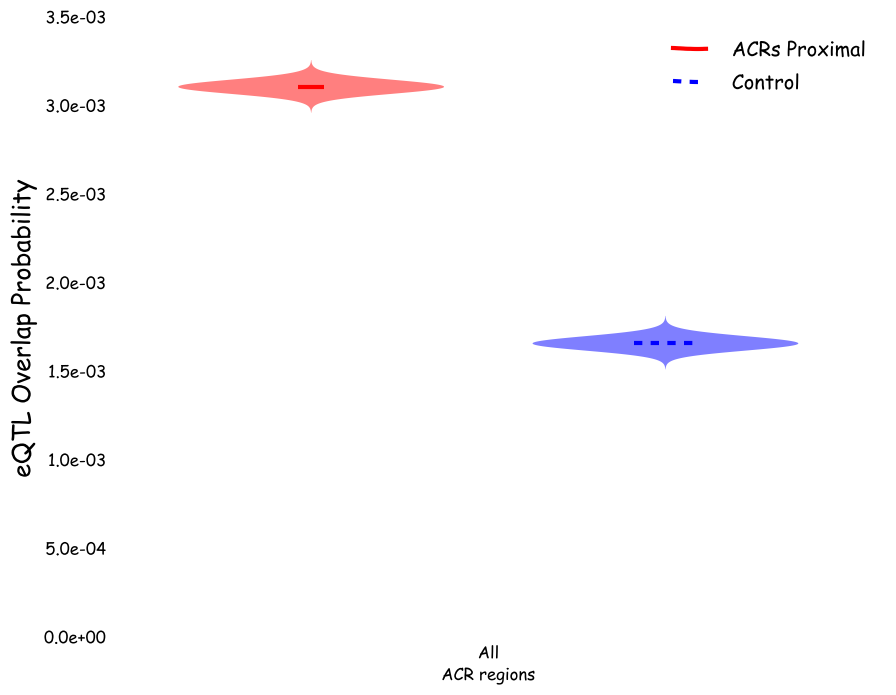

In [47]:
%matplotlib inline 
import matplotlib.ticker as mtick
from matplotlib import rc

plt.close()
plt.rc('font',**{'family':'serif','serif':['Times New Roman'],'size':12})
max_pt = 0.007
min_pt = 0.
fig = plt.figure(facecolor='White',figsize=(10,8))
ax = fig.add_subplot(111) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for contrast,(hot_node,ctrl_node,seq_type) in enumerate(comparisons):
    if contrast < 2:
        continue;
    for tissue in ('union',):
        i = 0       
        if contrast == 2:
            center_v1=2*i+width/2.
            pos_start_mean= (2*i+width/4.)+0.15
            pos_end_mean= (2*i+3*width/4.)-0.15
            draw_violin(ax, xgrid, beta.pdf(xgrid, analysis_graphs[tissue].node[hot_node]['eqtl']+a,
                                    analysis_graphs[tissue].node[hot_node]['non-eqtl']+b),
                                    center_v1, width=0.75, color='White',facecolor='b',linewidth=1,
                                    alpha=0.5, edgecolor='none')
            
            plt.hlines(beta.mean(analysis_graphs[tissue].node[hot_node]['eqtl']+a,
                             analysis_graphs[tissue].node[hot_node]['non-eqtl']+b),
                        pos_start_mean, pos_end_mean,
                        color='b', linewidth=3, label='ACRs Proximal',linestyles='-')
        else:
            plt.hlines(beta.mean(analysis_graphs[tissue].node[hot_node]['eqtl']+a,
                             analysis_graphs[tissue].node[hot_node]['non-eqtl']+b),
                        pos_start_mean, pos_end_mean,
                        color='b', linewidth=3, linestyles='-')
        
        if contrast == 2:
            center_v2=2*i+1+width/2.    
            pos_start_mean_v2= (2*i+1+width/2.-width/4.)+0.10
            pos_end_mean_v2= (2*i+1+width/2.+width/4.)-0.10
            
            draw_violin(ax, xgrid, beta.pdf(xgrid, analysis_graphs[tissue].node[ctrl_node]['eqtl']+a,
                                    analysis_graphs[tissue].node[ctrl_node]['non-eqtl']+b),
                                    center_v2,
                                    width=width,color='White',facecolor='k',linewidth=1,
                                    alpha=0.3, edgecolor='none')
        if contrast == 2:
            plt.hlines(beta.mean(analysis_graphs[tissue].node[ctrl_node]['eqtl']+a,
                             analysis_graphs[tissue].node[ctrl_node]['non-eqtl']+b),
                        pos_start_mean_v2, pos_end_mean_v2,
                        color='k', linewidth=3, label='Control',linestyle='dashed')


plt.xticks(np.arange(0,8,2)+width+(1.-width)/2.,
           [''])
plt.ylabel('eQTL Posterior Probability',fontsize=20)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.tick_params(top='off', bottom='on', left='on', right='off',which='major',labelsize=16)
plt.tick_params(axis='both',which='minor',labelsize=16)
plt.xlim([-width/4.,2*i+2])
plt.ylim([min_pt,max_pt])
plt.legend(loc='best',frameon=False)                   
#plt.savefig(os.path.join(wdir,'bZIP_ZmTFLG2_gc_graph_KK_eqtls.posterior.probabilities.pdf'), 
#           bbox_inches='tight', format='pdf')
#plt.close()

In [18]:
#this is the contrast between 
#'m2':['m2a','m2b','m2c'], # Differentiate between ACRs proximal and distal

sim_ACRs = beta.rvs(analysis_graphs['union'].node['m2b']['eqtl']+1,
                     analysis_graphs['union'].node['m2b']['non-eqtl']+1,
                     size=100000)
sim_nonACRs = beta.rvs(analysis_graphs['union'].node['m2c']['eqtl']+1,
                     analysis_graphs['union'].node['m2c']['non-eqtl']+1,
                     size=100000)

print 'Enrichment - ACRs proximal <2kb vs distal >2kb \n'
print scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),2.5), scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),97.5)

Enrichment - ACRs proximal <2kb vs distal >2kb 

2.22257015607 3.00503713127


In [19]:
#this is the contrast between 
#['m2c','m2d'] - Differentiate between ACR distal and control
sim_ACRs = beta.rvs(analysis_graphs['union'].node['m2c']['eqtl']+1,
                     analysis_graphs['union'].node['m2c']['non-eqtl']+1,
                     size=100000)
sim_nonACRs = beta.rvs(analysis_graphs['union'].node['m2d']['eqtl']+1,
                     analysis_graphs['union'].node['m2d']['non-eqtl']+1,
                     size=100000)

print 'Enrichment - ACRs distal vs control distal >2kb\n'
print scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),2.5), scoreatpercentile(np.divide(sim_ACRs,sim_nonACRs),97.5)

Enrichment - ACRs distal vs control distal >2kb

1.74712182252 2.45885896901
